In [ ]:
!pip install annoy

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from annoy import AnnoyIndex

import joblib

from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
try:
  df = pd.read_json('News_Category_Dataset_v3.json', lines=True)
except ValueError as e:
  print(f'Error: {e}')

In [ ]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [ ]:
df.shape

(209527, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [ ]:
df.isnull().sum() / df.shape[0] # % of missing values

link                 0.0
headline             0.0
category             0.0
short_description    0.0
authors              0.0
date                 0.0
dtype: float64

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.duplicated().sum()

13

In [ ]:
df = df.drop_duplicates()
df.duplicated().any()

False

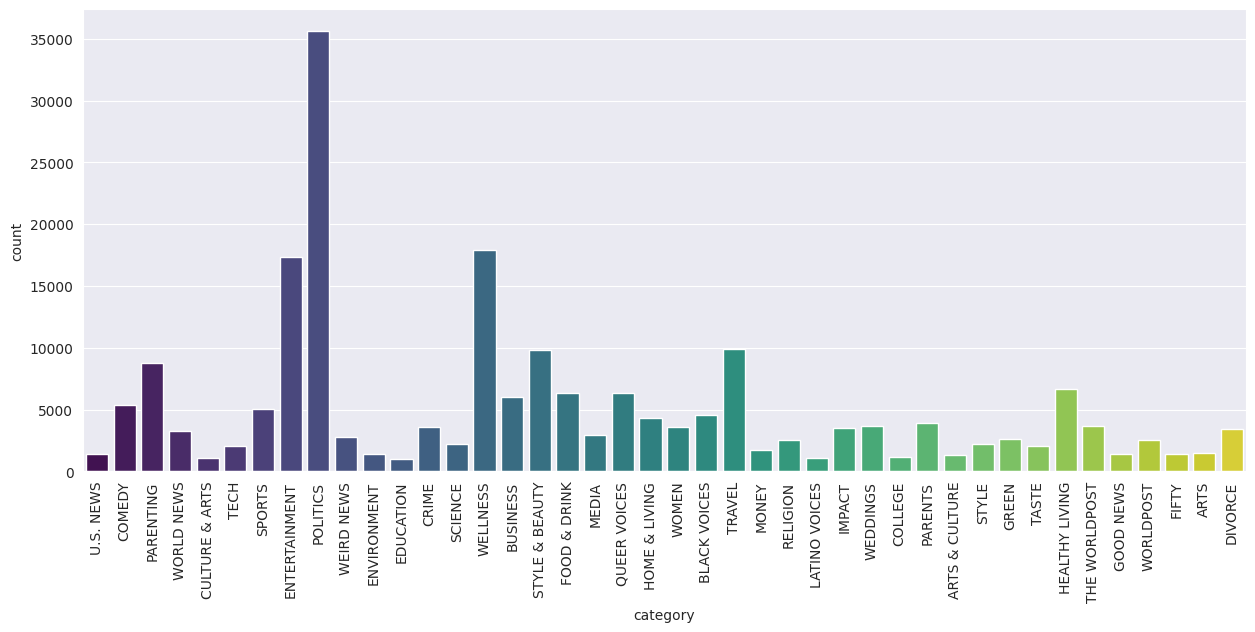

In [ ]:
# Distribution of Articles Across Categories
sns.set_style('darkgrid')
plt.figure(figsize=(15, 6))
sns.countplot(x=df['category'], palette='viridis')
plt.xticks(rotation=90)
plt.show()

In [ ]:
len(df['category'].unique())

42

In [ ]:
df.category = df.category.replace({"HEALTHY LIVING": "WELLNESS",
              "QUEER VOICES": "GROUPS VOICES",
              "BUSINESS": "BUSINESS & FINANCES",
              "PARENTS": "PARENTING",
              "BLACK VOICES": "GROUPS VOICES",
              "THE WORLDPOST": "WORLD NEWS",
              "STYLE": "STYLE & BEAUTY",
              "GREEN": "ENVIRONMENT",
              "TASTE": "FOOD & DRINK",
              "WORLDPOST": "WORLD NEWS",
              "SCIENCE": "SCIENCE & TECH",
              "TECH": "SCIENCE & TECH",
              "MONEY": "BUSINESS & FINANCES",
              "ARTS": "ARTS & CULTURE",
              "COLLEGE": "EDUCATION",
              "LATINO VOICES": "GROUPS VOICES",
              "CULTURE & ARTS": "ARTS & CULTURE",
              "FIFTY": "MISCELLANEOUS",
              "GOOD NEWS": "MISCELLANEOUS"}
            )

In [ ]:
len(df['category'].unique())

27

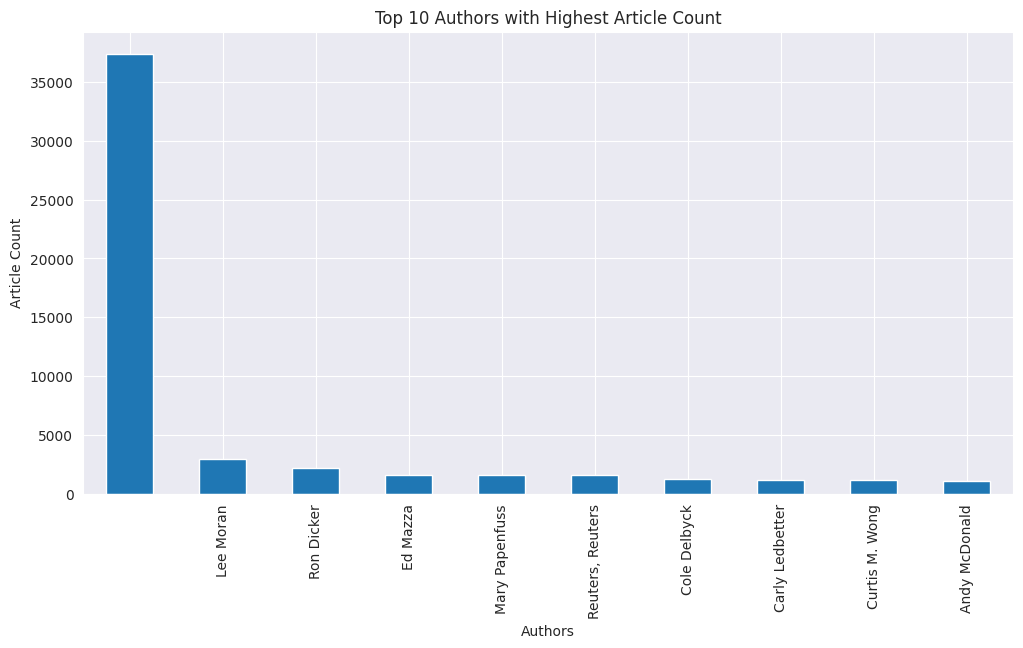

In [ ]:
# Author with the highest number of articles
top_authors = df['authors'].value_counts().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_authors.plot(kind='bar')
plt.title('Top 10 Authors with Highest Article Count')
plt.xlabel('Authors')
plt.ylabel('Article Count')
plt.show()

**The bar representing the highest article count is missing an author's name label. This label is crucial for the accurate representation and recognition of the author's contributions.**

The absence of the label may lead to misinterpretation of the data and fail to provide due credit to the author with the most articles. It also hinders our ability to analyze the data accurately and completely.

*To rectify this issue, a thorough investigation is necessary to understand the underlying reasons behind this occurrence.*

In [ ]:
df['authors'].unique()

array(['Carla K. Johnson, AP', 'Mary Papenfuss', 'Elyse Wanshel', ...,
       'Courtney Garcia, Contributor\nI tell stories and drink wine.',
       'Mateo Gutierrez, Contributor\nArtist',
       'John Giacobbi, Contributor\nTales from the Interweb by The Web Sheriff'],
      dtype=object)

In [ ]:
def is_empty(text):
  return pd.isnull(text) or str(text).strip() == ''

In [ ]:
empty_headlines_count = df['headline'].apply(is_empty).sum()
empty_descriptions_count = df['short_description'].apply(is_empty).sum()
empty_author_count = df['authors'].apply(is_empty).sum()
empty_category_count = df['category'].apply(is_empty).sum()

# Print the results
print(f"Number of samples with empty 'headline': {empty_headlines_count}")
print(f"Number of samples with empty 'short_description': {empty_descriptions_count}")
print(f"Number of samples with empty 'author': {empty_author_count}")
print(f"Number of samples with empty 'category': {empty_category_count}")


Number of samples with empty 'headline': 6
Number of samples with empty 'short_description': 19712
Number of samples with empty 'author': 37405
Number of samples with empty 'category': 0


## **Handling Missing Data**
* Since the number of samples with empty **'headline'** is small (6), we may consider dropping these rows as it won't significantly impact the overall dataset.

* For the **'short_description'**and **'authors'** columns, we have a substantial number of samples with missing values. Instead of dropping these rows, we can fill the missing values with a placeholder or an appropriate strategy.

In [ ]:
# Drop rows with empty headlines
df['headline'] = df['headline'].replace('', np.nan)
df.dropna(subset=['headline'], inplace=True)

# Fill missing 'short_description' and 'authors' with a placeholder(e.g., 'Not avialable' or 'Unknown)
df['short_description'] = df['short_description'].replace('', 'No description available')
df['authors'] = df['authors'].mask(df['authors'] == '', 'Unknown')

In [ ]:
filtered_df = df[(df['short_description'] != 'No description available') & (df['authors'] != 'Unknown')]
sampled_df = filtered_df.groupby('category', group_keys=False).apply(lambda x: x.sample(min(len(x), 500)))
sampled_df.reset_index(drop=True, inplace=True)

In [ ]:
sampled_df.shape

(13500, 6)

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))
def clean_text(text):
  """
    preprocesses input text by converting to lowercase,
    removing non-alphanumeric characters and digits,
    tokenizing using word_tokenize,
    lemmatizing with WordNet lemmatizer,
    and removing English stopwords.
  """

  text = text.lower()
  text = re.sub(r'<[^>]+>', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\d+', '', text)
  tokens = word_tokenize(text)
  tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

  return ' '.join(tokens)

In [ ]:
lemmatizer = WordNetLemmatizer()
sampled_df['text']  = sampled_df['headline'] + ' ' + sampled_df['short_description'] + ' ' + sampled_df['category']
sampled_df['text'] = sampled_df['text'].apply(clean_text)

In [ ]:
tfidf = TfidfVectorizer()
text_feature_vectorized = vectorizer.fit_transform(sampled_df['text'])
joblib.dump(tfidf, 'text_vectorizer.joblib')
vectorizer = joblib.load('text_vectorizer.joblib')

In [ ]:
# Convert sparse matrix to dense array
dense_text_feature_vectorized = text_feature_vectorized.toarray()
# Initialize AnnoyIndex
f = dense_text_feature_vectorized.shape[1]  # dimension of vectors
t = AnnoyIndex(f, 'angular')  # Using 'angular' as a proxy for cosine similarity
# add items to AnnoyIndex
for i in range(dense_text_feature_vectorized.shape[0]):
    v = dense_text_feature_vectorized[i]
    t.add_item(i, v)
# Build AnnoyIndex with 10 trees
t.build(10)
t.save('articles_index.ann')
# Loading the pre-built AnnoyIndex for quick recommendations
u = AnnoyIndex(f, 'angular')
u.load('articles_index.ann')

True

# **Recommendation System**

In [ ]:
def headline_recommendation(headline, num_recommendations=5):
  article_index = sampled_df[sampled_df['headline'] == headline].index.tolist()
  if not article_index:
    return f'No article found with the headline {headline}'
  article_id = article_index[0]
  similar_items = u.get_nns_by_item(article_id, num_recommendations+1)
  article_indices = [i for i in similar_items if i != article_id]
  return sampled_df.iloc[article_indices][['headline', 'link', 'category', 'date']]


In [ ]:
headline = sampled_df.headline[3]
headline

'10 Women Photographers Who Are Changing The Way We See The World'

In [ ]:
headline_recommendation(headline)

,headline,link,category,date
428,Ethereal Photographs Capture The World Of Snails,https://www.huffingtonpost.com/entry/katarzyna...,ARTS & CULTURE,2016-06-20
443,"Our 16 Favorite Arts, Books And Culture Storie...",https://www.huffingtonpost.com/entry/favorite-...,ARTS & CULTURE,2015-12-28
26,When Photography Becomes More Than Just Taking...,https://www.huffingtonpost.com/entry/when-phot...,ARTS & CULTURE,2015-02-17
356,D.C. Museum Dedicated To Women In Art Broke At...,https://www.huffingtonpost.com/entry/museum-wo...,ARTS & CULTURE,2017-01-27
245,Artist Photographs Diverse American 'Neighbors...,https://www.huffingtonpost.com/entry/artist-ph...,ARTS & CULTURE,2016-07-27


# **Recommendation System for unseen Articles**

In [ ]:
def vectorize_new_headline(headline, vectorizer):
  if not hasattr(vectorizer, 'idf_'):
        vectorizer.fit(sampled_df['text'])
  return vectorizer.transform([new_headline]).toarray().flatten()

def recommendation_function(sampled_df, headline, vectorizer, u, num_recommendations=5):
  try:
      article_index = sampled_df[sampled_df['headline'] == headline].index.tolist()

      if article_index:
        article_id = article_index[0]
        similar_items = u.get_nns_by_item(article_id, num_recommendations+1)
        article_indices = [i for i in similar_items if i != article_id]
      else:
        headline_vector = vectorize_new_headline(headline, vectorizer).flatten()
        similar_items = u.get_nns_by_vector(headline_vector, num_recommendations)
        article_indices = similar_items

      return sampled_df.iloc[article_indices][['headline', 'link', 'category', 'date']]
  except Exception as e:
    return f'Error : {str(e)}'

In [ ]:
# Example usage:
new_headline = "10 Step To Successfully Outsourcing Your Online Business"
recommendation_function(sampled_df, new_headline, vectorizer, u)

,headline,link,category,date
1295,10 Tiebreakers The Supreme Court Should Use To...,https://www.huffingtonpost.com/entry/supreme-c...,COMEDY,2016-02-15
9662,The Only 5 Steps You Need To Get Ready For A F...,https://www.huffingtonpost.com/entry/getting-r...,STYLE & BEAUTY,2013-11-22
2350,How to Handle the Inevitable Online Dating Dri...,https://www.huffingtonpost.com/entry/how-to-ha...,DIVORCE,2013-05-22
683,What To Buy On Black Friday At Target,https://www.huffingtonpost.com/entry/what-to-b...,BUSINESS & FINANCES,2017-11-15
723,10 Ways To Be Authentic Online,https://www.huffingtonpost.com/entry/10-ways-t...,BUSINESS & FINANCES,2014-12-09
